# Final Project : 3D reconstruction with multi-images

## CS445: Computational Photography - Fall 2019

### Part I: SfM from two images <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
from numpy.linalg import svd, inv, solve, lstsq
import utils
import scipy
from scipy.sparse.linalg import lsqr
from scipy.sparse import csr_matrix
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
from collections import defaultdict

import structure
import processor
import features


In [2]:

class Camera(object):
    """ Class for representing pin-hole camera """

    def __init__(self, P=None, K=None, R=None, t=None):
        """ P = K[R|t] camera model. (3 x 4)
         Must either supply P or K, R, t """
        if P is None:
            try:
                self.extrinsic = np.hstack([R, t])
                P = np.dot(K, self.extrinsic)
            except TypeError as e:
                print('Invalid parameters to Camera. Must either supply P or K, R, t')
                raise

        self.P = P     # camera matrix
        self.K = K     # intrinsic matrix
        self.R = R     # rotation
        self.t = t     # translation
        self.c = None  # camera center

    def project(self, X):
        """ Project 3D homogenous points X (4 * n) and normalize coordinates.
            Return projected 2D points (2 x n coordinates) """
        x = np.dot(self.P, X)
        x[0, :] /= x[2, :]
        x[1, :] /= x[2, :]

        return x[:2, :]

    def qr_to_rq_decomposition(self):
        """ Convert QR to RQ decomposition with numpy.
        Note that this could be done by passing in a square matrix with scipy:
        K, R = scipy.linalg.rq(self.P[:, :3]) """
        Q, R = np.linalg.qr(np.flipud(self.P).T)
        R = np.flipud(R.T)
        return R[:, ::-1], Q.T[::-1, :]

    def factor(self):
        """ Factorize the camera matrix P into K,R,t with P = K[R|t]
          using RQ-factorization """
        if self.K is not None and self.R is not None:
            return self.K, self.R, self.t  # Already been factorized or supplied

        K, R = self.qr_to_rq_decomposition()
        # make diagonal of K positive
        T = np.diag(np.sign(np.diag(K)))
        if np.linalg.det(T) < 0:
            T[1, 1] *= -1

        self.K = np.dot(K, T)
        self.R = np.dot(T, R)  # T is its own inverse
        self.t = np.dot(np.linalg.inv(self.K), self.P[:, 3])

        return self.K, self.R, self.t

    def center(self):
        """  Compute and return the camera center. """
        if self.c is not None:
            return self.c
        elif self.R:
            # compute c by factoring
            self.c = -np.dot(self.R.T, self.t)
        else:
            # P = [M|−MC]
            self.c = np.dot(-np.linalg.inv(self.c[:, :3]), self.c[:, -1])
        return self.c



## Find Common Points in Frames

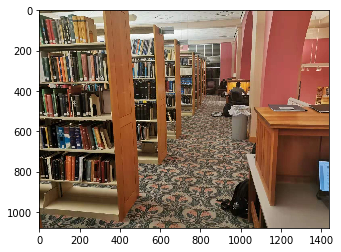

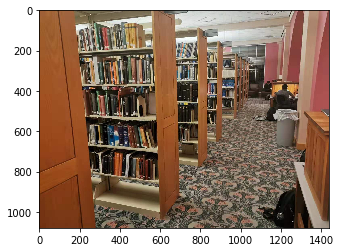

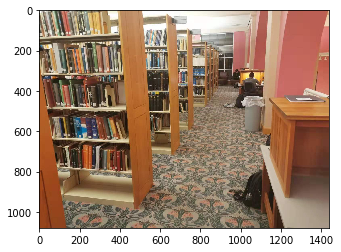

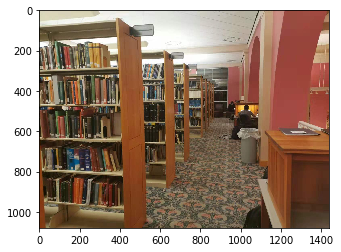

In [3]:
# images location
im1 = './images/final/5001.jpg'
im2 = './images/final/5002.jpg'
im3 = './images/final/5003.jpg'
im4 = './images/final/5004.jpg'

# Load an color image in grayscale
im1 = cv2.cvtColor(cv2.imread(im1),cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread(im2),cv2.COLOR_BGR2RGB)
im3 = cv2.cvtColor(cv2.imread(im3),cv2.COLOR_BGR2RGB)
im4 = cv2.cvtColor(cv2.imread(im4),cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()
plt.imshow(im3)
plt.show()
plt.imshow(im4)
plt.show()

In [4]:
def convert_kps_to_array(kp):
    return np.float([kp[idx].pt for idx in range(0, len(kp))]).reshape(-1, 1, 2)

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)
kp3, des3 = sift.detectAndCompute(im3,None)
kp4, des4 = sift.detectAndCompute(im4,None)

print(type(kp1))
print(len(kp1))

key_pts_1 = np.asarray([kp1[i].pt for i in range(len(kp1))])
key_pts_2 = np.asarray([kp2[i].pt for i in range(len(kp2))])
key_pts_3 = np.asarray([kp3[i].pt for i in range(len(kp3))])
key_pts_4 = np.asarray([kp4[i].pt for i in range(len(kp4))])


# BFMatcher with default params
bf = cv2.BFMatcher()
matches_1_2 = bf.knnMatch(des1,des2, k=2)
matches_1_3 = bf.knnMatch(des1,des3, k=2)
matches_1_4 = bf.knnMatch(des1,des4, k=2)

<class 'list'>
11856


In [6]:


'''
matches: <list<list<cv2.DMatch>>: [num of matches, 2]
cv2.DMatch:
float  distance
 
int  imgIdx   train image index More...
 
int queryIdx  query descriptor index More...
 
int trainIdx train descriptor index More...

'''

# Apply ratio test
# get all good matches
good_1_2 = []
good_1_3 = []
good_1_4 = []

for m,n in matches_1_2:
    if m.distance < 0.75*n.distance:
        good_1_2.append([m])
        
for m,n in matches_1_3:
    if m.distance < 0.75*n.distance:
        good_1_3.append([m])
        
for m,n in matches_1_4:
    if m.distance < 0.75*n.distance:
        good_1_4.append([m])
        

In [7]:
print(len(good_1_2))
print(type(good_1_2[0]))
#print(good_1_2[0])

from functools import reduce
from collections import defaultdict

def extract_match_index_in_kpts(good_match):
    ret_query = []
    ret_train = []
    for mat in good_match:
        ret_query.extend([mat[i].queryIdx for i in range(5 if 5<len(mat) else len(mat))])
        ret_train.extend([mat[i].trainIdx for i in range(5 if 5<len(mat) else len(mat))])
    return ret_query, ret_train

def find_common_index(good_index):
    res = list(reduce(lambda i, j: i & j, (set(x) for x in good_index))) 
    return res

def build_matching_dict(good_index_1, good_index_2):
    ret = defaultdict()
    for i in range(len(good_index_1)):
        ret[good_index_1[i]] = good_index_2[i]
    return ret

def find_common_index_on_other_three_frames(common_1, good_index_1_to_2, good_index_1_to_3, good_index_1_to_4):
    common_2 = []
    common_3 = []
    common_4 = []
    for i in common_1:
        common_2.append(good_index_1_to_2[i])
        common_3.append(good_index_1_to_3[i])
        common_4.append(good_index_1_to_4[i])
    return common_1, common_2, common_3, common_4

def find_common_index_on_frames(common_1, good_index_others):
    common_index_batch = [common_1]
    for j in range(len(good_index_others)):
        common_index = []
        for i in common_1:
            common_index.append(good_index_others[j][i])
        common_index_batch.append(common_index)
    return common_index_batch


def find_common_points_by_index(kpts, common_index):
    common_pts_1 = []
    common_pts_2 = []
    common_pts_3 = []
    common_pts_4 = []
    for j in range(len(common_index[0])):
        common_pts_1.append(kpts[0][common_index[0][j]].pt)
        common_pts_2.append(kpts[1][common_index[1][j]].pt)
        common_pts_3.append(kpts[2][common_index[2][j]].pt)
        common_pts_4.append(kpts[3][common_index[3][j]].pt)
    return common_pts_1, common_pts_2, common_pts_3, common_pts_4


def find_common_points_on_frames_by_index(kpts, common_index):
    common_pts_batch = []
    for i in range(len(common_index)):
        common_pts = []
        for j in range(len(common_index[i])):
            common_pts.append(kpts[i][common_index[i][j]].pt)
        common_pts_batch.append(common_pts)
    return common_pts_batch
        
        
    
good_index_1_2_in_1, good_index_1_2_in_2 = extract_match_index_in_kpts(good_1_2)
good_index_1_3_in_1, good_index_1_3_in_3 = extract_match_index_in_kpts(good_1_3)
good_index_1_4_in_1, good_index_1_4_in_4 = extract_match_index_in_kpts(good_1_4)

#build matching index dict
good_index_1_to_2 = build_matching_dict(good_index_1_2_in_1, good_index_1_2_in_2)
good_index_1_to_3 = build_matching_dict(good_index_1_3_in_1, good_index_1_3_in_3)
good_index_1_to_4 = build_matching_dict(good_index_1_4_in_1, good_index_1_4_in_4)

#print(len(good_index_1_2_in_1))
common_1 = find_common_index([good_index_1_2_in_1, good_index_1_3_in_1, good_index_1_4_in_1])
#print(common_1)
common_1, common_2, common_3, common_4 = find_common_index_on_other_three_frames(common_1,  good_index_1_to_2, good_index_1_to_3, good_index_1_to_4)
print(len(common_1))
print(len(common_2))
print(len(common_3))
print(len(common_4))

common_pts_1, common_pts_2, common_pts_3, common_pts_4 = find_common_points_by_index([kp1, kp2, kp3, kp4], [common_1, common_2, common_3, common_4])
#print(common_pts_1)



3074
<class 'list'>
633
633
633
633


In [8]:
common_pts_1 = np.asarray(common_pts_1)
common_pts_2 = np.asarray(common_pts_2)
common_pts_3 = np.asarray(common_pts_3)
common_pts_4 = np.asarray(common_pts_4)

_, mask_1_2 = cv2.findHomography(common_pts_1, common_pts_2, cv2.RANSAC,10.0)
_, mask_1_3 = cv2.findHomography(common_pts_1, common_pts_3, cv2.RANSAC,10.0)
_, mask_1_4 = cv2.findHomography(common_pts_1, common_pts_4, cv2.RANSAC,10.0)
total_mask = mask_1_2*mask_1_3*mask_1_4
#print(total_mask.shape)

581


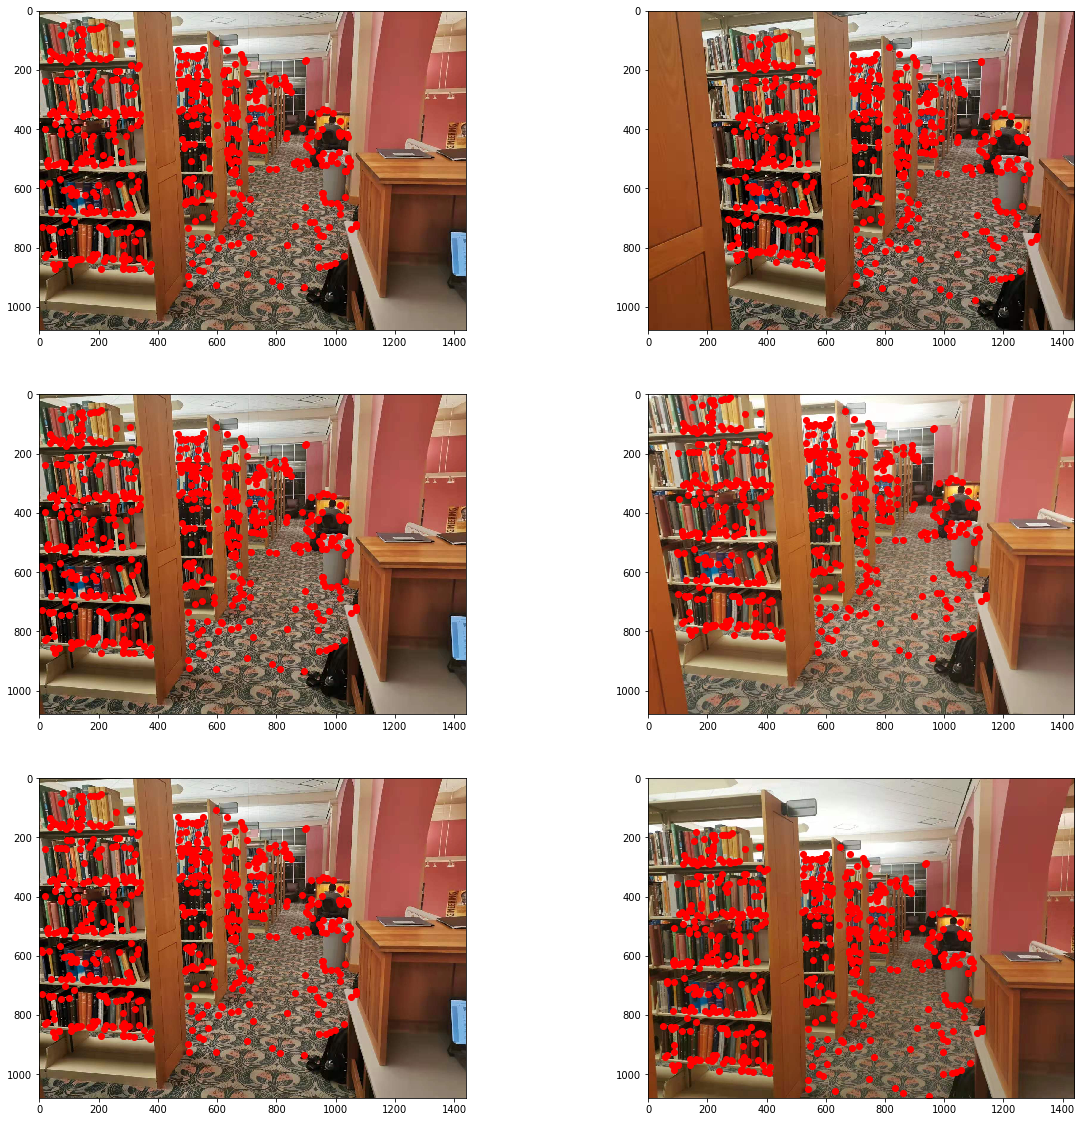

In [9]:
fig, axes = plt.subplots(3, 2, False, False, True, subplot_kw=None, gridspec_kw=None, num = 0,  figsize=(20,20))

#Visualization
def get_correct_march_points_RANSAC(pts, mask):
    dot_list_y = []
    dot_list_x = []
    for i in range(common_pts_1.shape[0]):
        #print(int(i[1]),int(i[0]))
        #im1_copy[int(i[1]),int(i[0]),:] = np.asarray([0,255,255])[:]
        if (mask[i][0]):
            dot_list_y.append(pts[i][1])
            dot_list_x.append(pts[i][0])
    return dot_list_x, dot_list_y
        

axes[0,0].imshow(im1)
dot_list_x, dot_list_y = get_correct_march_points_RANSAC(common_pts_1, total_mask)
print(len(dot_list_x))
axes[0,0].plot(dot_list_x, dot_list_y, 'ro')

dot_list_x, dot_list_y = get_correct_march_points_RANSAC(common_pts_2, total_mask)
axes[0,1].imshow(im2)
axes[0,1].plot(dot_list_x, dot_list_y, 'ro')

dot_list_x, dot_list_y = get_correct_march_points_RANSAC(common_pts_1, total_mask)
axes[1,0].imshow(im1)
axes[1,0].plot(dot_list_x, dot_list_y, 'ro')

dot_list_x, dot_list_y = get_correct_march_points_RANSAC(common_pts_3, total_mask)
axes[1,1].imshow(im3)
axes[1,1].plot(dot_list_x, dot_list_y, 'ro')

dot_list_x, dot_list_y = get_correct_march_points_RANSAC(common_pts_1, total_mask)
axes[2,0].imshow(im1)
axes[2,0].plot(dot_list_x, dot_list_y, 'ro')

dot_list_x, dot_list_y = get_correct_march_points_RANSAC(common_pts_4, total_mask)
axes[2,1].imshow(im4)
axes[2,1].plot(dot_list_x, dot_list_y, 'ro')

plt.show()

## Keypoints Match & RANSAC

In [63]:
'''
Func:
    return a batch of corresponding points in a batch of images
Params:
    img_file_names: the file dir for all images
    batch_size: the batch size, must be greater the num of items in img_file_names
RetVal:
    [],[] for failure
    img_file_names, match_key_pts_centered_at_frame_zero_x_y_batch for success:
            img_file_names: the remaining file dirs to be process (N-batch_size)
            match_key_pts_centered_at_frame_zero_x_y_batch:
                for each frame fi, find the common corresponding points that appears in all frames on fi
                thus, stored in an list [[x values of corresponding points for frame 0, y values of corresponding points for frame 0],
                                        [x values of corresponding points for frame 1, y values of corresponding points for frame 1],
                                        ...
                                        [x values of corresponding points for frame n, y values of corresponding points for frame n]]
    shape : F, 2, P
'''
def get_batch_correspondense(img_file_names, batch_size, feature_extractor):
    if (len(img_file_names)<batch_size):
        return [],[]
    im_batch = []      #batch
    key_pts_batch = []     #batch
    kp_batch = []
    match_key_pts_batch = []  #batch-1
    good_match_key_pts_batch = []
    good_match_index_dict_batch = []
    good_match_index_batch = []
    mask_batch = []
    des_batch = []
    match_key_pts_centered_at_frame_zero_x_y_batch = []
    # Load an color image in grayscale
    for i in range(batch_size):
        file_name = img_file_names.pop(0)
        print(file_name)
        image = cv2.cvtColor(cv2.imread(file_name),cv2.COLOR_BGR2RGB)
        im_batch.append(image)
        if feature_extractor=="sift":
            kp, des = sift.detectAndCompute(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY),None)
            
        elif feature_extractor=="orb":
            kp, des = orb.detectAndCompute(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY),None)
        elif feature_extractor=="flann":
            kp, des = surf.detectAndCompute(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY),None)
        kp_batch.append(kp)
        key_pts_batch.append(np.asarray([kp[i].pt for i in range(len(kp))]))
        #print(len(kp))
        des_batch.append(des)
    
    for i in range(1, batch_size):
        good = []
        if feature_extractor=="sift":
            #print("aa",des_batch[0].shape)
            match_key_points = bf.knnMatch(des_batch[0],des_batch[i], k=2)
            match_key_pts_batch.append(match_key_points)
            # get all good matches
            
            for m,n in match_key_points:
                if m.distance < 1*n.distance:
                    good.append([m])
            good_match_key_pts_batch.append(good)
            
        elif feature_extractor=="orb":
            matches = bf.match(des_batch[0],des_batch[i])
            matches = sorted(matches, key = lambda x:x.distance)
            print(len(matches))
   
            if len(matches)>400:
                matches = matches[:399]
            for match_pts in matches:
                good.append([match_pts])
            good_match_key_pts_batch.append(good)
        elif feature_extractor=="flann":
            FLANN_INDEX_KDTREE = 0
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            flann = cv2.FlannBasedMatcher(index_params, search_params)
            match_key_points = flann.knnMatch(des_batch[0],des_batch[i], k=2)

            # store all the good matches as per Lowe's ratio test.
            match_key_pts_batch.append(match_key_points)
            # get all good matches
            
            for m,n in match_key_points:
                if m.distance < 1*n.distance:
                    good.append([m])
            good_match_key_pts_batch.append(good)
        good_index_1_2_in_1, good_index_1_2_in_2 = extract_match_index_in_kpts(good)
        #print(len(good_index_1_2_in_2))
        #build matching index dict
        good_match_index_batch.append(good_index_1_2_in_1)
        good_match_index_dict_batch.append(build_matching_dict(good_index_1_2_in_1, good_index_1_2_in_2))
    #print(len(good_match_index_batch))
    common_1 = find_common_index(good_match_index_batch)
    #print(common_1)
    common_other_frames = find_common_index_on_frames(common_1, good_match_index_dict_batch)
    #print(common_other_frames)
    common_pts_batch = np.asarray(find_common_points_on_frames_by_index(kp_batch, common_other_frames))
    #print(np.asarray(common_pts_batch).shape)
    #print(np.asarray(common_pts_batch))
     
    total_mask = 1.
    for i in range(1, batch_size):
        if feature_extractor == "sift":
            thredshold = 10.0
        elif feature_extractor == "orb":
            thredshold = 50
        elif feature_extractor == "flann":
            thredshold = 10.0
        total_mask = total_mask * cv2.findHomography(common_pts_batch[0], common_pts_batch[i], cv2.RANSAC, thredshold)[1]
    #print(np.asarray(mask_batch).shape)
    #print(mask_batch)
    #print(total_mask) 
    
    for i in range(batch_size):
        dot_list_y = []
        dot_list_x = []
        for j in range(common_pts_batch[i].shape[0]):
            #print(int(i[1]),int(i[0]))
            #im1_copy[int(i[1]),int(i[0]),:] = np.asarray([0,255,255])[:]
            if (total_mask[j][0]>0.5):
                dot_list_y.append(common_pts_batch[i][j][1])
                dot_list_x.append(common_pts_batch[i][j][0])
        #print(np.asarray(dot_list_y).shape)
        match_key_pts_centered_at_frame_zero_x_y_batch.append([dot_list_x, dot_list_y])
        #print(matched_key_pts_centered_at_frame_zero_x_y_batch.shape)
    return img_file_names, im_batch, match_key_pts_centered_at_frame_zero_x_y_batch
    
   

In [64]:
    
import glob
image_file_names = glob.glob("./images/sample/*.png")[:]
#print(image_file_names)
#image_file_names = ['./images/final/5001.jpg', './images/final/5002.jpg', './images/final/5003.jpg', './images/final/5004.jpg']
bf = cv2.BFMatcher()
surf = cv2.xfeatures2d.SURF_create(400)
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb = cv2.ORB_create()
_, im_batch, matched_key_pts_centered_at_frame_zero_x_y_batch = get_batch_correspondense(image_file_names, 8,"orb")
#bf = cv2.BFMatcher()
#bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#orb = cv2.ORB_create()
#image_file_names = glob.glob("./images/sample/*.png")[:8]
#_, im_batch, matched_key_pts_centered_at_frame_zero_x_y_batch = get_batch_correspondense(image_file_names, len(image_file_names),"sift")
print(np.asarray(matched_key_pts_centered_at_frame_zero_x_y_batch).shape)

./images/sample\hotel.seq0.png
./images/sample\hotel.seq1.png
./images/sample\hotel.seq10.png
./images/sample\hotel.seq11.png
./images/sample\hotel.seq12.png
./images/sample\hotel.seq13.png
./images/sample\hotel.seq14.png
./images/sample\hotel.seq15.png
500
500
500
500
500
500
500
(8, 2, 117)


## Visualize Matching With ORB

8
117
117
117
117


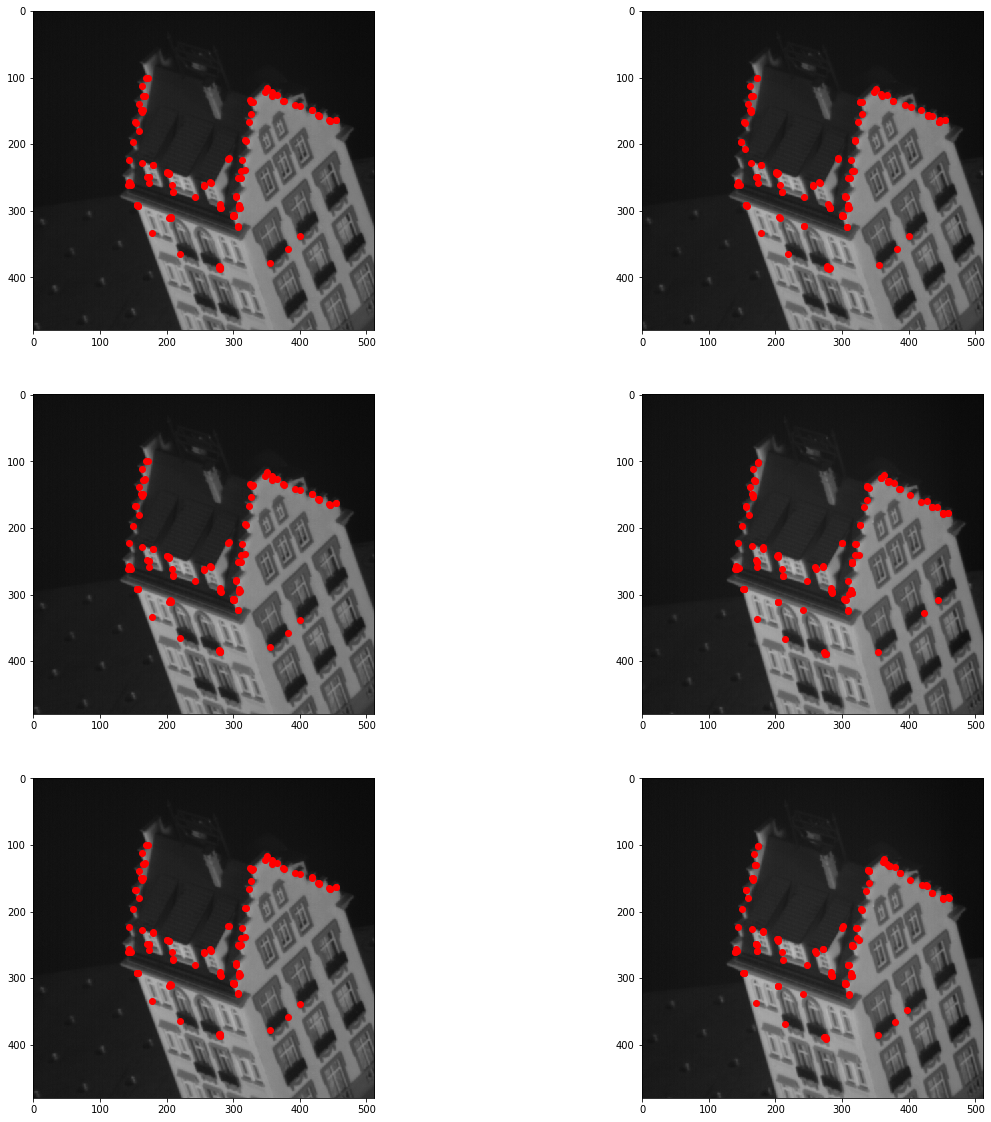

In [65]:
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[1][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[2][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[3][0]))

#print(matched_key_pts_centered_at_frame_zero_x_y_batch)
fig, axes = plt.subplots(3, 2, False, False, True, subplot_kw=None, gridspec_kw=None, num = 0,  figsize=(20,20))

axes[0,0].imshow(im_batch[0])
axes[0,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[0,1].imshow(im_batch[1])
axes[0,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[1][0], matched_key_pts_centered_at_frame_zero_x_y_batch[1][1], 'ro')

axes[1,0].imshow(im_batch[0])
axes[1,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[1,1].imshow(im_batch[2])
axes[1,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[2][0], matched_key_pts_centered_at_frame_zero_x_y_batch[2][1], 'ro')

axes[2,0].imshow(im_batch[0])
axes[2,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[2,1].imshow(im_batch[3])
axes[2,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[3][0], matched_key_pts_centered_at_frame_zero_x_y_batch[3][1], 'ro')

plt.show()
fig.savefig("result_corresponding_orb.jpg")

## Visualize Matching With Sift

./images/sample\hotel.seq0.png
./images/sample\hotel.seq1.png
./images/sample\hotel.seq10.png
./images/sample\hotel.seq11.png
./images/sample\hotel.seq12.png
./images/sample\hotel.seq13.png
./images/sample\hotel.seq14.png
./images/sample\hotel.seq15.png
(8, 2, 114)
8
114
114
114
114


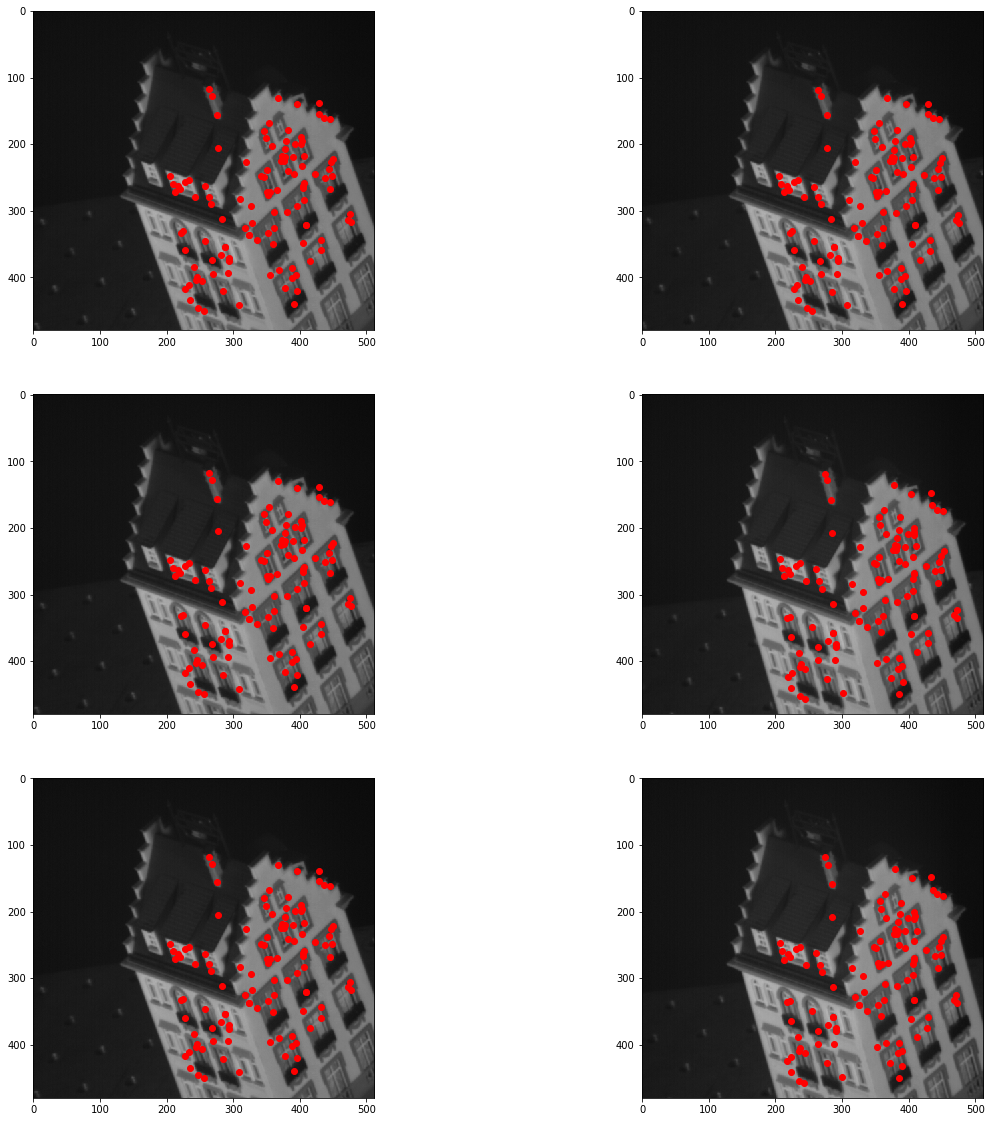

In [66]:
bf = cv2.BFMatcher()
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb = cv2.ORB_create()
image_file_names = glob.glob("./images/sample/*.png")[:]
_, im_batch, matched_key_pts_centered_at_frame_zero_x_y_batch = get_batch_correspondense(image_file_names, 8,"sift")
print(np.asarray(matched_key_pts_centered_at_frame_zero_x_y_batch).shape)


print(len(matched_key_pts_centered_at_frame_zero_x_y_batch))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[1][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[2][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[3][0]))

#print(matched_key_pts_centered_at_frame_zero_x_y_batch)
fig, axes = plt.subplots(3, 2, False, False, True, subplot_kw=None, gridspec_kw=None, num = 0,  figsize=(20,20))

axes[0,0].imshow(im_batch[0])
axes[0,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[0,1].imshow(im_batch[1])
axes[0,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[1][0], matched_key_pts_centered_at_frame_zero_x_y_batch[1][1], 'ro')

axes[1,0].imshow(im_batch[0])
axes[1,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[1,1].imshow(im_batch[2])
axes[1,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[2][0], matched_key_pts_centered_at_frame_zero_x_y_batch[2][1], 'ro')

axes[2,0].imshow(im_batch[0])
axes[2,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[2,1].imshow(im_batch[3])
axes[2,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[3][0], matched_key_pts_centered_at_frame_zero_x_y_batch[3][1], 'ro')

plt.show()
fig.savefig("result_corresponding_sift.jpg")

## Flann Match

./images/sample\hotel.seq0.png
./images/sample\hotel.seq1.png
./images/sample\hotel.seq10.png
./images/sample\hotel.seq11.png
./images/sample\hotel.seq12.png
./images/sample\hotel.seq13.png
./images/sample\hotel.seq14.png
./images/sample\hotel.seq15.png
(8, 2, 118)
8
118
118
118
118


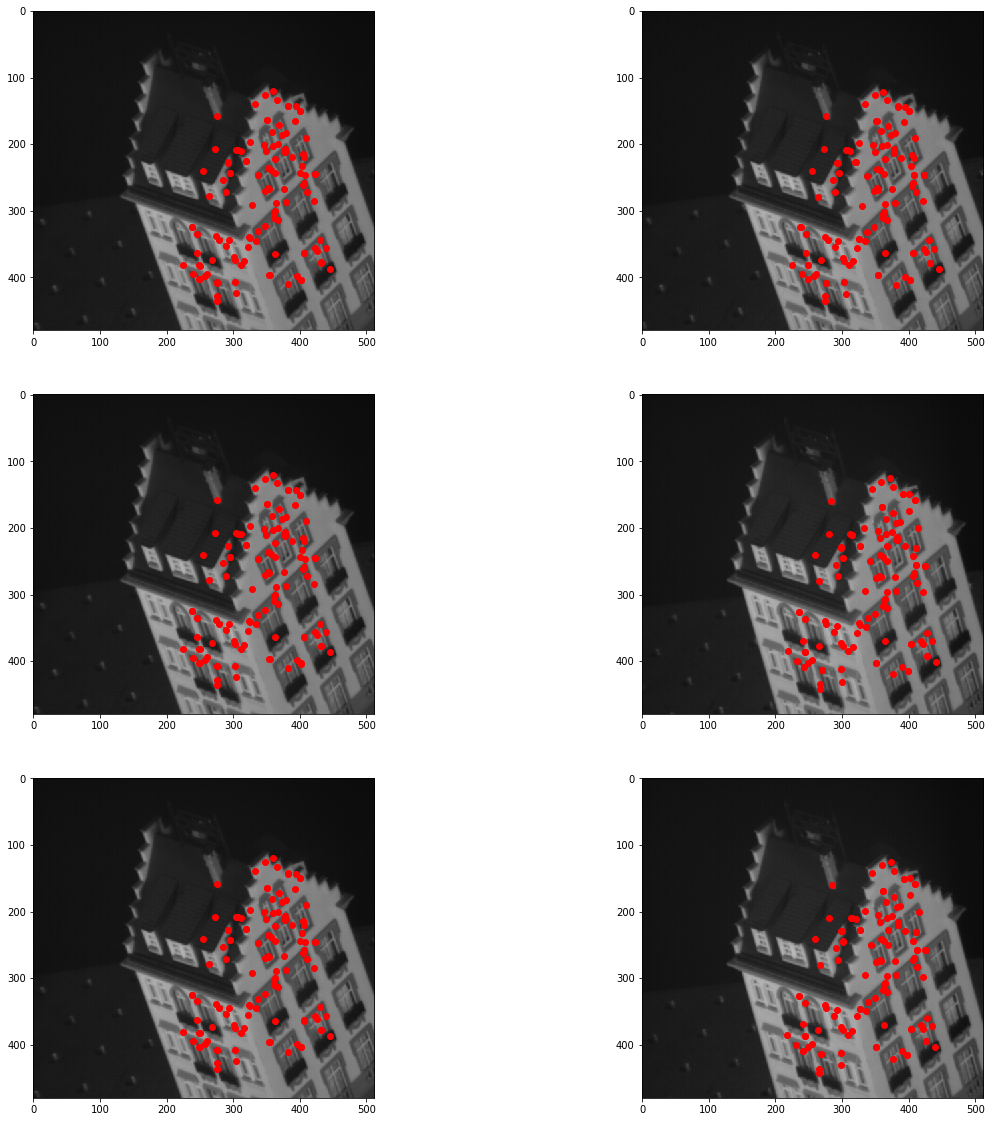

In [67]:
bf = cv2.BFMatcher()
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
orb = cv2.ORB_create()
image_file_names = glob.glob("./images/sample/*.png")[:]
_, im_batch, matched_key_pts_centered_at_frame_zero_x_y_batch = get_batch_correspondense(image_file_names, 8,"flann")
print(np.asarray(matched_key_pts_centered_at_frame_zero_x_y_batch).shape)


print(len(matched_key_pts_centered_at_frame_zero_x_y_batch))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[1][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[2][0]))
print(len(matched_key_pts_centered_at_frame_zero_x_y_batch[3][0]))

#print(matched_key_pts_centered_at_frame_zero_x_y_batch)
fig, axes = plt.subplots(3, 2, False, False, True, subplot_kw=None, gridspec_kw=None, num = 0,  figsize=(20,20))

axes[0,0].imshow(im_batch[0])
axes[0,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[0,1].imshow(im_batch[1])
axes[0,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[1][0], matched_key_pts_centered_at_frame_zero_x_y_batch[1][1], 'ro')

axes[1,0].imshow(im_batch[0])
axes[1,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[1,1].imshow(im_batch[2])
axes[1,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[2][0], matched_key_pts_centered_at_frame_zero_x_y_batch[2][1], 'ro')

axes[2,0].imshow(im_batch[0])
axes[2,0].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[0][0], matched_key_pts_centered_at_frame_zero_x_y_batch[0][1], 'ro')

axes[2,1].imshow(im_batch[3])
axes[2,1].plot(matched_key_pts_centered_at_frame_zero_x_y_batch[3][0], matched_key_pts_centered_at_frame_zero_x_y_batch[3][1], 'ro')

plt.show()
fig.savefig("result_corresponding_sift.jpg")

## Calculate 3D Position with Respect to the Center of the Object

In [68]:
import numpy as np
import scipy
def sym_params(i,j):
    """ params of Q for iQQTj"""
    o=np.outer(i,j)
    o=o+o.T-np.diag(o.diagonal())
    return o[np.triu_indices(3)]
def tomasi_kanade(W0):
    """ Tomasi–Kanade factorization
        input:
        W0 - coordinates of shape (Frames,Points,2)
        output:
        R - (2*Frames,3)
        S - (3,Points)
        """
    F,P,_=W0.shape
    # (2F,P) 2F stack Xs and Ys
    W=W0.transpose(2,0,1).reshape(F*2,P).astype(np.float64)
    # normalize to centroid
    W-=W.mean(axis=1,keepdims=True)
    # svd, (2F,P), (,P), (P,P)
    # svd 2F<P, (2F,2F), (,2F), (2F,P)
    u, s, vh =np.linalg.svd(W,full_matrices=True)
    # (2F,3),(3,P)
    R_hat=u[:,:3]*(s[:3]**0.5)
    S_hat=((s[:3]**0.5)*vh[:3,:].T).T
    # (F,3) (F,3)
    I,J=R_hat[:F,:],R_hat[F:,:]
    # solve Q*QT, symmetric, 6 params
    # iTQi=1 jTQj=1 iTQj=0 R=[i,j,k]T
    A=np.zeros([3*F,6])
    A[:F,:]=np.array([sym_params(I[i],I[i]) for i in range(len(I))])
    A[F:2*F,:]=np.array([sym_params(J[i],J[i]) for i in range(len(I))])
    A[2*F:,:]=np.array([sym_params(I[i],J[i]) for i in range(len(I))])
    # ii,jj are 1, ij are 0
    b=np.ones([3*F])
    b[2*F:]=0
    # solve QQT
    qsym=np.linalg.lstsq(A,b)[0]
    # get symmetric mat
    QSym=np.zeros([3,3])
    QSym[np.triu_indices(3)]=qsym
    QSym[np.tril_indices(3,k=-1)]=QSym[np.triu_indices(3,k=1)]
    try:
        Q=np.linalg.cholesky(QSym).T
    except:
        print("Bad Data")
        return None,None
    # get R,S
    R=R_hat.dot(Q)
    S=np.linalg.inv(Q).dot(S_hat)
    return R,S

In [69]:
def removeNaN(a):
    b=[]
    for i in range(a.shape[0]):
        if (a[i].max()>-1e10):
            b.append(a[i])
    return np.array(b)

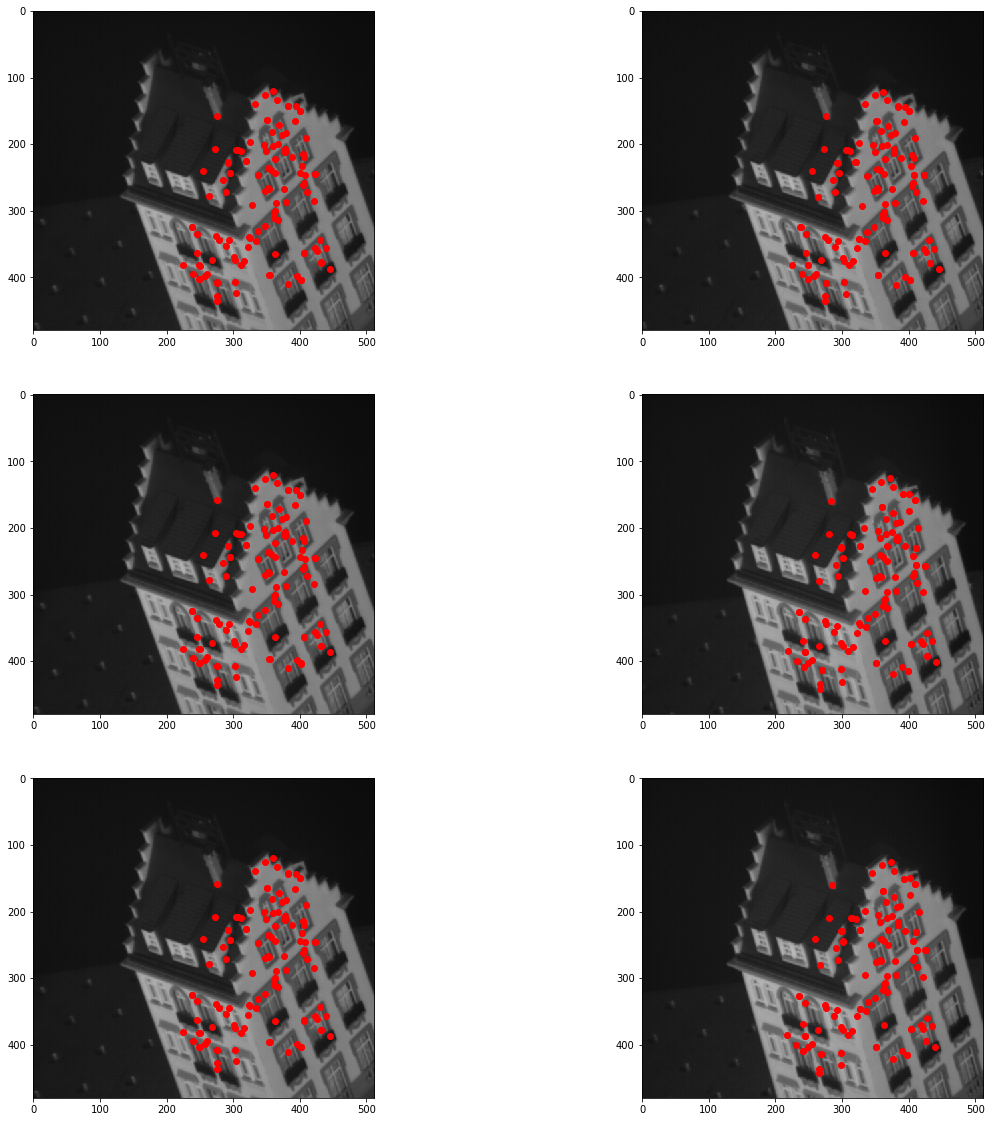

(3, 118)


C:\Users\anban\Anaconda3\envs\tfenv\lib\site-packages\ipykernel_launcher.py:39: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [70]:
import scipy.io
#matdata=scipy.io.loadmat("tracked_points")
#Xs=matdata['Xs']
#Ys=matdata['Ys']

#Wmat=removeNaN(np.stack((Xs,Ys)).transpose([2,1,0])).transpose([1,0,2])
#matched_key_pts_centered_at_frame_zero_x_y_batch : F, 2, P
matched_key_pts_centered_at_frame_zero_x_y_batch = np.asarray(matched_key_pts_centered_at_frame_zero_x_y_batch)
F_P_ = matched_key_pts_centered_at_frame_zero_x_y_batch.shape
#print(matched_key_pts_centered_at_frame_zero_x_y_batch[:,:,1])
Wmat = np.transpose(matched_key_pts_centered_at_frame_zero_x_y_batch, (0, 2, 1))    #F, P, 2

#print(matched_key_pts_centered_at_frame_zero_x_y_batch)
fig, axes = plt.subplots(3, 2, False, False, True, subplot_kw=None, gridspec_kw=None, num = 0,  figsize=(20,20))

axes[0,0].imshow(im_batch[0])
axes[0,0].plot(Wmat[0,:,0], Wmat[0,:,1], 'ro')

axes[0,1].imshow(im_batch[1])
axes[0,1].plot(Wmat[1,:,0], Wmat[1,:,1], 'ro')

axes[1,0].imshow(im_batch[0])
axes[1,0].plot(Wmat[0,:,0], Wmat[0,:,1], 'ro')

axes[1,1].imshow(im_batch[2])
axes[1,1].plot(Wmat[2,:,0], Wmat[2,:,1], 'ro')

axes[2,0].imshow(im_batch[0])
axes[2,0].plot(Wmat[0,:,0], Wmat[0,:,1], 'ro')

axes[2,1].imshow(im_batch[3])
axes[2,1].plot(Wmat[3,:,0], Wmat[3,:,1], 'ro')

plt.show()
#print(Wmat[:,1,:])
#print(Wmat.shape)   #F, P, 2
#print(Wmat[:,1])
R,S=tomasi_kanade(Wmat)
print(S.shape)

In [71]:
from plotly.offline import plot
import chart_studio.plotly as py
import plotly.graph_objs as go
import numpy as np
tripoints3d=S # (3,P)
fig = go.Figure(data=[go.Scatter3d(x=tripoints3d[0],
                                   y=tripoints3d[1],
                                   z=tripoints3d[2],
                                   mode='markers')])
plot(fig, filename='3d-axis-range')

C:\Users\anban\Anaconda3\envs\tfenv\lib\site-packages\plotly\offline\offline.py:562: UserWarning:

Your filename `3d-axis-range` didn't end with .html. Adding .html to the end of your file.



'3d-axis-range.html'

In [72]:
def get_Homology_with_triangle(mesh_1, mesh_2):
    if (mesh_1.shape != mesh_2.shape):
        print("Size error!!!")
        return
    num_tri = mesh_1.shape[0]
    transform = []
    for i in range(num_tri):
        #prepare data format
        #print(mesh_1[i])
        m1 = np.concatenate([np.reshape(mesh_1[i].T, (2,3)),np.asarray([[1.,1.,1.]])],axis=0)
        m2 =  np.concatenate([np.reshape(mesh_2[i].T, (2,3)),np.asarray([[1.,1.,1.]])],axis=0)
        # A*m1 = m2
        A = np.dot(m2,np.linalg.inv(m1))
        transform.append(A)
    return transform

        
#transform = get_Homology_with_triangle(tri_mesh1, tri_mesh2)



(3, 118)
[ 60.582996 -40.496536 -78.33989 ]
(2, 118)
(118, 2)
(222, 3)


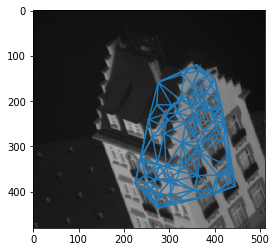

(222, 3, 2)
[-3.879353e-07 -4.445092e-08 -4.525912e-07]


In [73]:
def tri_mesh(im, points_stack):
    #print(points1_stack.shape)
    tri = Delaunay(points_stack)#triangulate the rectangle U
    print(tri.simplices.shape)
    #print(tri.simplices[0])
    #plt.imshow(im)
    #plt.triplot(points_stack[:,0], points_stack[:,1], tri.simplices.copy())
    #plt.show()
    return tri


tripoints3d_simple = S
print(tripoints3d_simple.shape)
tripoints3d_simple = tripoints3d_simple.astype(np.float32)
num_points = tripoints3d_simple.shape[1]
print(tripoints3d_simple[:,0])
uv1 = matched_key_pts_centered_at_frame_zero_x_y_batch[0]
print(uv1.shape)
point_dense_stack = np.stack([uv1[0,:],uv1[1,:]],-1)
print(point_dense_stack.shape)
tri_dense = tri_mesh(0, point_dense_stack)
plt.imshow(im_batch[0])
plt.triplot(point_dense_stack[:,0], point_dense_stack[:,1], tri_dense.simplices.copy())
plt.show()
all_dense_tri_mesh1 = point_dense_stack[tri_dense.simplices]
print(all_dense_tri_mesh1.shape)
num_tri = all_dense_tri_mesh1.shape[0]
dense_default_dict = defaultdict()
for i in range(num_points):
    key_to_3d = str(uv1[0,i])+str(uv1[1,i])
    value = tripoints3d_simple[:3,i]
    key_to_2d = str(value[0])+str(value[1])+str(value[2])
    dense_default_dict[key_to_3d] = value, i
    dense_default_dict[key_to_2d] = uv1[:,i], i
    
triangle_list = []
normal_list = []
first = None
center = np.average(tripoints3d_simple[:3,:], axis = -1)
print(center)

# Write Result to 3D File

### STL string format

In [74]:
for i in range(num_tri):
    triangle = all_dense_tri_mesh1[i]
    V1 = dense_default_dict[str(triangle[0][0])+str(triangle[0][1])][0]
    V2 = dense_default_dict[str(triangle[1][0])+str(triangle[1][1])][0]
    V3 = dense_default_dict[str(triangle[2][0])+str(triangle[2][1])][0]
    triangle_list.append([V1, V2, V3])
    #calculate surface normal
    E1 = V1 - V2
    E2 = V2 - V3
    V_hat = V1+V2+V3
    N = np.cross(E1, E2)
    if (V_hat - center).dot(N)<0:
        N = -N
    normal_list.append(N.astype(np.float32))
    
print(len(triangle_list))
print(triangle_list[0])
print(len(normal_list))    

import os, sys

# Open a file
fd = os.open( "test.stl", os.O_RDWR|os.O_CREAT )

# Now get a file object for the above file.
fo = os.fdopen(fd, "w+")


def write_to_ascii_stl(triangles, normals):
    fo.write("solid test\n")   #file header
    template_facet = "    facet normal {} {} {}\n\
        outer loop\n\
            vertex {} {} {}\n\
            vertex {} {} {}\n\
            vertex {} {} {}\n\
        endloop\n\
    endfacet\n"
    
    for i in range(len(triangles)):
        str_ = template_facet.format(str(normals[i][0]), str(normals[i][1]), str(normals[i][2]),\
                                    str(triangles[i][0][0]), str(triangles[i][0][1]), str(triangles[i][0][2]),\
                                    str(triangles[i][1][0]), str(triangles[i][1][1]), str(triangles[i][1][2]),\
                                    str(triangles[i][2][0]), str(triangles[i][2][1]), str(triangles[i][2][2]),\
                                    )
        fo.write(str_)
    print("finish writing")
    fo.write("endsolid test\n")
    

write_to_ascii_stl(triangle_list, normal_list)
fo.close()

222
[array([149.62123 ,  64.913864, 116.140114], dtype=float32), array([171.4837  ,  21.442036,  48.13122 ], dtype=float32), array([138.63374 ,  83.3429  ,  99.853264], dtype=float32)]
222
finish writing


### PLY format with color

In [75]:
print(tripoints3d_simple[:3,:].T.shape)

(118, 3)


In [76]:
'''
ply
format ascii 1.0
comment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''
element vertex 8
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
element face 6
property list uchar uint vertex_indices
end_header
1.000000 1.000000 -1.000000 255 255 255
1.000000 -1.000000 -1.000000 255 255 255
-1.000000 -1.000000 -1.000000 255 255 255
-1.000000 1.000000 -1.000000 255 255 255
1.000000 0.999999 1.000000 255 255 255
-1.000000 1.000000 1.000000 255 255 255
-1.000000 -1.000000 1.000000 255 255 255
0.999999 -1.000001 1.000000 255 255 255
4 0 1 2 3
4 4 5 6 7
4 0 4 7 1
4 1 7 6 2
4 2 6 5 3
4 4 0 3 5 
'''
tri_pts = tripoints3d_simple[:3,:].T
vertices_num = tri_pts.shape[0]

face_num = num_tri
head = "ply\nformat ascii 1.0\ncomment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''\nelement vertex %d\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nelement face %d\nproperty list uchar uint vertex_indices\nend_header\n" %(vertices_num,face_num)
#print(head)
vertices = ""
import random

im1 = im_batch[0]
#vertices
for i in range(tri_pts.shape[0]):
    key = str(tri_pts[i][0])+str(tri_pts[i][1])+str(tri_pts[i][2])
    uv_, _ = dense_default_dict[key]
    #print(uv_)
    vertices += "%.6f %.6f %.6f %d %d %d\n"%(tri_pts[i][0],tri_pts[i][1],tri_pts[i][2], im1[int(uv_[1]),int(uv_[0])][0], im1[int(uv_[1]),int(uv_[0])][1], im1[int(uv_[1]),int(uv_[0])][2])
#print(vertices[:100])
#random.randint(0, 255),  random.randint(0, 255),  random.randint(0, 255))

#faces
faces = ""
for i in range(num_tri):
    triangle = all_dense_tri_mesh1[i]
    V1 = dense_default_dict[str(triangle[0][0])+str(triangle[0][1])][1]
    V2 = dense_default_dict[str(triangle[1][0])+str(triangle[1][1])][1]
    V3 = dense_default_dict[str(triangle[2][0])+str(triangle[2][1])][1]
    
    faces += "3 %d %d %d\n"%(V1, V2, V3)

#print(faces[:100])
ply_file_content = head + vertices + faces
#print(ply_file_content)

# Open a file
fd = os.open( "test_with_color.ply", os.O_RDWR|os.O_CREAT )

# Now get a file object for the above file.
fo = os.fdopen(fd, "w+")
fo.write(ply_file_content)
fo.close()
print("finish writing!")

finish writing!


### PLY with dense map

im1
(96, 102)
(9792, 2)


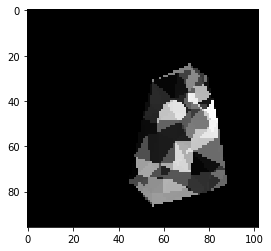

512.0


In [77]:
def demo_triangular_fit(im, tri):
    """
    Ret : which_tri: the triangle each uv position belong to
            uv: the mesh_grid
    """
    W = int(im.shape[1]/5)
    H = int(im.shape[0]/5)
    x = np.linspace(0,im.shape[1],W)
    y = np.linspace(0,im.shape[0],H)
    u,v=np.meshgrid(x,y)
    #print(u)
    #print("\n")
    #print(v)
    u=u.flatten()
    v=v.flatten()
    #print(u.shape)
    #print("\n")
    #print(v.shape)
    uv = np.stack([u,v],-1)
    #print(uv.shape)
    #print(uv)
    which_tri = tri.find_simplex(uv)
    #print(which_tri)
    which_tri = np.reshape(which_tri,(H,W))
    print(which_tri.shape)
    print(uv.shape)
    return which_tri, uv

print("im1")
which_tri_1, uv1 = demo_triangular_fit(im_batch[0], tri_dense)
plt.imshow((which_tri_1+1)/np.max(which_tri_1),cmap = 'gray')
plt.show()


print(np.max(uv1))


In [78]:
#print(np.max(which_tri_1))
#print(all_dense_tri_mesh1.shape)
    
vertices_set_3d = []
vertices_set_2d = []
#uv1 = matched_key_pts_centered_at_frame_zero_x_y_batch[0].T
print(uv1.shape)
for i in range(uv1.shape[0]):
    x = uv1[i][0]
    y = uv1[i][1]
    #print(x,y)
    which_tri = tri_dense.find_simplex(np.array([x,y]).T)
    #print(which_tri)
    if which_tri==-1:
        continue
    #print(which_tri)
    tri_ = all_dense_tri_mesh1[which_tri]
    #print(x,y)
    #print(tri_)

    #linear interpolation
    #P1*x1+P2*x2+P3*x3 = u
    #P1*y1+P2*y2+P3*y3 = v
    #P1*1+P2*1+P3 = 1
    #a = np.array([[x1,x2,x3], [y1,y2,y3], [1,1,1]])
    #b = np.array([u,v,1])
    #x = np.linalg.solve(a, b)
    a = np.array([[tri_[0][0],tri_[1][0],tri_[2][0]], [tri_[0][1],tri_[1][1],tri_[2][1]], [1, 1, 1]])
    b = np.array([x,y,1])
    P = np.linalg.solve(a, b)
    #print(P)
    V1 = dense_default_dict[str(tri_[0][0])+str(tri_[0][1])][0]
    V2 = dense_default_dict[str(tri_[1][0])+str(tri_[1][1])][0]
    V3 = dense_default_dict[str(tri_[2][0])+str(tri_[2][1])][0]
    pts_in_3d = V1*P[0]+V2*P[1]+V3*P[2]
   
    vertices_set_3d.append(pts_in_3d)
    vertices_set_2d.append([x,y])

vertices_set_3d = np.asarray(vertices_set_3d)
vertices_set_2d = np.asarray(vertices_set_2d)
print(vertices_set_3d.shape)
print(vertices_set_2d.shape)

        

(9792, 2)
(1908, 3)
(1908, 2)


### Brief Preview of Dense Map

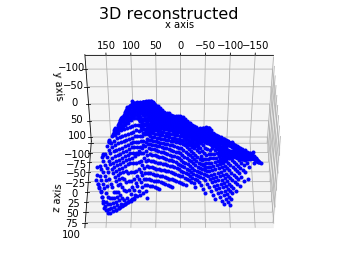

In [79]:
vertices_set_3d_ = vertices_set_3d.T
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.gca(projection='3d')
ax.plot(vertices_set_3d_[0], vertices_set_3d_[1], vertices_set_3d_[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()

### Dot Cloud in PLY


In [80]:
'''
ply
format ascii 1.0
comment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''
element vertex 8
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
property list uchar uint vertex_indices
end_header
1.000000 1.000000 -1.000000 255 255 255
1.000000 -1.000000 -1.000000 255 255 255
-1.000000 -1.000000 -1.000000 255 255 255
-1.000000 1.000000 -1.000000 255 255 255
1.000000 0.999999 1.000000 255 255 255
-1.000000 1.000000 1.000000 255 255 255
-1.000000 -1.000000 1.000000 255 255 255
0.999999 -1.000001 1.000000 255 255 255
'''
vertices_num = vertices_set_3d.shape[0]
print(vertices_num)
head = "ply\nformat ascii 1.0\ncomment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''\nelement vertex %d\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nelement face 0\nproperty list uchar uint vertex_indices\nend_header\n" %(vertices_num)
#print(head)
vertices = ""
#vertices
for i in range(vertices_num):
    #if (i%100==0):
        #print(i)
    #print(uv_)
    vertices += "%.6f %.6f %.6f %d %d %d\n"%(vertices_set_3d[i][0],vertices_set_3d[i][1],vertices_set_3d[i][2], im1[int(vertices_set_2d[i][1]),int(vertices_set_2d[i][0])][0], im1[int(vertices_set_2d[i][1]),int(vertices_set_2d[i][0])][1], im1[int(vertices_set_2d[i][1]),int(vertices_set_2d[i][0])][2])
#print(vertices[:100])
print(i)

#print(faces[:100])
ply_file_content = head + vertices
print(ply_file_content)

# Open a file
fd = os.open( "test_color_and_dense.ply", os.O_RDWR|os.O_CREAT )

# Now get a file object for the above file.
fo = os.fdopen(fd, "w+")
fo.write(ply_file_content)
fo.close()
#os.close(fd)
print("finish writing!")

1908
1907
ply
format ascii 1.0
comment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''
element vertex 1908
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
element face 0
property list uchar uint vertex_indices
end_header
-162.426300 27.415422 23.355692 27 27 27
-156.262207 36.202282 12.023078 139 139 139
-157.098206 31.196823 16.368589 113 113 113
-157.934174 26.191364 20.714100 39 39 39
-158.546326 21.119478 26.307556 76 76 76
-149.105911 44.736076 7.792002 137 137 137
-151.377411 40.074219 0.943901 139 139 139
-152.076630 35.040829 6.551791 139 139 139
-152.775879 30.007441 12.159681 128 128 128
-153.475113 24.974052 17.767572 97 97 97
-154.278061 19.961847 22.418016 123 123 123
-154.569458 14.794773 29.799816 113 113 113
-156.033401 10.606159 31.462334 36 36 36
-136.213409 57.105957 37.571011 53 53 53
-140.747879 52.984585 13.028310 136 136 136
-144.579941 48.691490 -6.183310 141 141 141
-146.533447 43

(1908, 2)
(3770, 3)


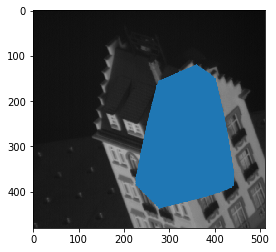

(3770, 3, 2)
[  3.9630895   5.2606697 -12.222605 ]


In [81]:
print(vertices_set_2d.shape)
dense_tri_mesh = tri_mesh(0, vertices_set_2d)
plt.imshow(im_batch[0])
plt.triplot(vertices_set_2d[:,0], vertices_set_2d[:,1], dense_tri_mesh.simplices.copy())
plt.show()
all_dense_tri_mesh1_dense = vertices_set_2d[dense_tri_mesh.simplices]
print(all_dense_tri_mesh1_dense.shape)
num_tri = all_dense_tri_mesh1_dense.shape[0]
num_points = vertices_set_2d.shape[0]
dense_default_dict_dense = defaultdict()
for i in range(num_points):
    key_to_3d = str(vertices_set_2d[i,0])+str(vertices_set_2d[i,1])
    value = vertices_set_3d[i,:3]
    key_to_2d = str(value[0])+str(value[1])+str(value[2])
    dense_default_dict_dense[key_to_3d] = value, i
    dense_default_dict_dense[key_to_2d] = vertices_set_2d[i,:], i
    
triangle_list = []
normal_list = []
first = None
center = np.average(vertices_set_3d[:,:3], axis = 0)
print(center)

In [82]:
'''
ply
format ascii 1.0
comment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''
element vertex 8
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
element face 6
property list uchar uint vertex_indices
end_header
1.000000 1.000000 -1.000000 255 255 255
1.000000 -1.000000 -1.000000 255 255 255
-1.000000 -1.000000 -1.000000 255 255 255
-1.000000 1.000000 -1.000000 255 255 255
1.000000 0.999999 1.000000 255 255 255
-1.000000 1.000000 1.000000 255 255 255
-1.000000 -1.000000 1.000000 255 255 255
0.999999 -1.000001 1.000000 255 255 255
4 0 1 2 3
4 4 5 6 7
4 0 4 7 1
4 1 7 6 2
4 2 6 5 3
4 4 0 3 5 
'''
tri_pts = vertices_set_3d[:,:3]
vertices_num = tri_pts.shape[0]
face_num = num_tri
head = "ply\nformat ascii 1.0\ncomment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''\nelement vertex %d\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nelement face %d\nproperty list uchar uint vertex_indices\nend_header\n" %(vertices_num,face_num)
#print(head)
vertices = ""
import random
print(head)
im1 = im_batch[0]
#vertices
for i in range(tri_pts.shape[0]):
    key = str(tri_pts[i][0])+str(tri_pts[i][1])+str(tri_pts[i][2])
    uv_, _ = dense_default_dict_dense[key]
    #print(uv_)
    vertices += "%.6f %.6f %.6f %d %d %d\n"%(tri_pts[i][0],tri_pts[i][1],tri_pts[i][2], im1[int(uv_[1]),int(uv_[0])][0], im1[int(uv_[1]),int(uv_[0])][1], im1[int(uv_[1]),int(uv_[0])][2])
#print(vertices[:100])
#random.randint(0, 255),  random.randint(0, 255),  random.randint(0, 255))

#faces
faces = ""
for i in range(num_tri):
    triangle = all_dense_tri_mesh1_dense[i]
    V1 = dense_default_dict_dense[str(triangle[0][0])+str(triangle[0][1])][1]
    V2 = dense_default_dict_dense[str(triangle[1][0])+str(triangle[1][1])][1]
    V3 = dense_default_dict_dense[str(triangle[2][0])+str(triangle[2][1])][1]
    
    faces += "3 %d %d %d\n"%(V1, V2, V3)

#print(faces[:100])
ply_file_content = head + vertices + faces
#print(ply_file_content)

# Open a file
fd = os.open( "test_with_color_dense_surface.ply", os.O_RDWR|os.O_CREAT )

# Now get a file object for the above file.
fo = os.fdopen(fd, "w+")
fo.write(ply_file_content)
fo.close()
print("finish writing!")

ply
format ascii 1.0
comment Created by Blender 2.76 (sub 0) - www.blender.org, source file: ''
element vertex 1908
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
element face 3770
property list uchar uint vertex_indices
end_header

finish writing!
